This is a modification of [an example](https://github.com/lanl/scico/blob/main/examples/scripts/deconv_tv_admm.py) from the SCICO package

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import scico.numpy as snp
import scico.random
from jax import random
from matplotlib.colors import TwoSlopeNorm
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta
from scico import functional, linop, loss, metric
from scico.optimize.admm import ADMM, CircularConvolveSolver
from xdesign import SiemensStar, discrete_phantom

/data/venvs/base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/soft/scico-fork/scico/numpy/_wrappers.py:61: UserWarning: In call to wrap_recursively, name spacing is not in target_dict
  warnings.warn(f"In call to wrap_recursively, name {name} is not in target_dict")
/data/soft/scico-fork/scico/numpy/_wrappers.py:61: UserWarning: In call to wrap_recursively, name real_if_close is not in target_dict
  warnings.warn(f"In call to wrap_recursively, name {name} is not in target_dict")
/data/soft/scico-fork/scico/numpy/_wrappers.py:61: UserWarning: In call to wrap_recursively, name asanyarray is not in target_dict
  warnings.warn(f"In call to wrap_recursively, name {name} is not in target_dict")
/data/soft/scico-fork/scico/numpy/_wrappers.py:61: UserWarning: In call to wrap_recursively, name asmatrix 

# Create a ground truth image.

In [2]:
phantom = SiemensStar(32)
N = 256  # image size
x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU

# Simulate the signal

Set up the forward operator and create a test signal consisting of a
blurred signal with additive Gaussian noise.

In [ ]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
A = linop.CircularConvolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = scico.random.randn(Ax.shape, seed=0)
y = Ax + σ * noise

# Solve using ADMM

In [3]:
λ = 2e-2  # L21 norm regularization parameter
ρ = 5e-1  # ADMM penalty parameter
maxiter = 50  # number of ADMM iterations

f = loss.SquaredL2Loss(y=y, A=A)
# Penalty parameters must be accounted for in the gi functions, not as
# additional inputs.
g = λ * functional.L21Norm()  # regularization functionals gi
C = linop.FiniteDifference(x_gt.shape, circular=True)
solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=A.adj(y),
    maxiter=maxiter,
    subproblem_solver=CircularConvolveSolver(),
    itstat_options={"display": True, "period": 10},
)
solution = {"admm": solver.solve()}

Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  2.91e-01  2.706e+02  8.268e+00  6.982e+00
  10  5.18e-01  2.773e+02  4.006e-01  1.662e+00
  20  5.97e-01  2.754e+02  1.668e-01  9.856e-01
  30  6.81e-01  2.746e+02  9.411e-02  6.923e-01
  40  7.63e-01  2.742e+02  6.486e-02  5.095e-01
  49  8.30e-01  2.740e+02  4.885e-02  4.005e-01


# Now try the simplest model with numpyro

Neither attempt to match `sigma_dx` to `λ` used above, nor to learn it with a hyperprior.

In [ ]:
def deconvolution_tv(y, sigma_x=0.5, sigma_dx=0.1, sigma_y=0.1):
    """Probabilistic model of deconvolution with TV regularisation

    Parameters
    ----------

    y: jnp.ndarray, float
        Observed blurred and noisy 2D image with values between -1 and 1
    h_fft: jnp.ndarray, complex
        Convolution kernel in the fourier domain, DC component at [0,0]
    sigma_x: float
        Scale parameter for the Normal prior on the desired x
    sigma_dx: float
        Scale parameter for the Laplace prior on the gradient of the desired x
    sigma_y: float
        Standard deviation of the observation noise in y
    """

    with numpyro.plate_stack("ij", y.shape):
        x = numpyro.sample("x", dist.Normal(0.5, sigma_x))

    grad_x = jnp.stack(jnp.gradient(x), axis=0)
    with numpyro.plate_stack("ij", y.shape):
        with numpyro.plate("grad_component", y.ndim):
            numpyro.sample("laplace_prior_x", dist.Laplace(0.0, sigma_dx), obs=grad_x)

    y_pred = A(x)

    with numpyro.plate_stack("ij", y.shape):
        numpyro.sample("likelihood", dist.Normal(y_pred, sigma_y), obs=y)

In [4]:
guide = AutoDelta(deconvolution_tv)
optimizer = numpyro.optim.Adam(step_size=1e-2)
svi = SVI(deconvolution_tv, guide, optimizer, loss=Trace_ELBO())
res = svi.run(random.PRNGKey(0), num_steps=1_000, y=y, sigma_dx=0.75)
solution["svi"] = res.params["x_auto_loc"]
for k, v in res.params.items():
    if k != "x_auto_loc":
        print(k, v)

100%|█| 1000/1000 [00:03<00:00, 267.04it/s, init loss: 677785.2500, avg. loss [951-1000]: 31480


# Visualise the results

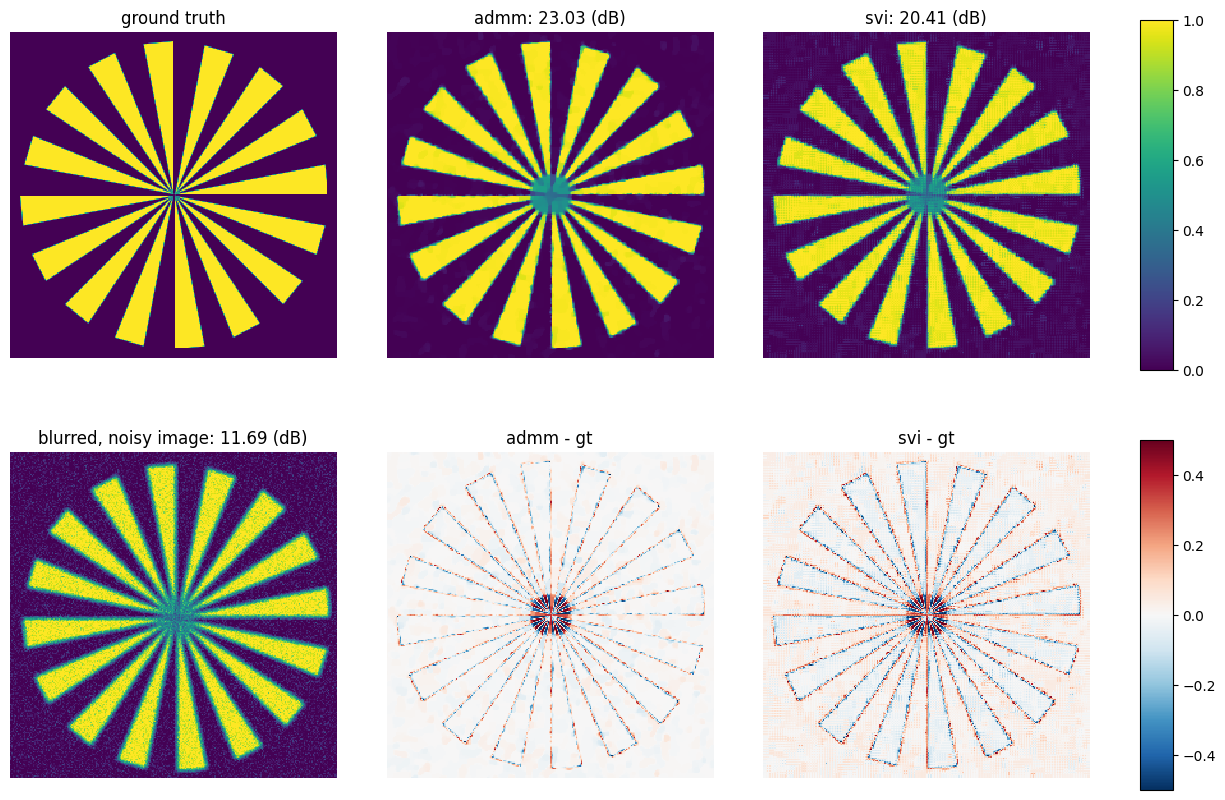

In [5]:
vmin, vmax = x_gt.min(), x_gt.max()

fig, axes = plt.subplots(
    nrows=2, ncols=4, figsize=(15, 10), gridspec_kw={"width_ratios": [10] * 3 + [1]}
)

im = axes[0, 0].imshow(x_gt, vmin=vmin, vmax=vmax, interpolation="none")
axes[0, 0].set_title("ground truth")

im = axes[1, 0].imshow(y, vmin=vmin, vmax=vmax, interpolation="none")
axes[1, 0].set_title("blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, y))

for ax_col, (method, arr) in zip(axes[:, 1:].T, solution.items()):
    ax_col[0].imshow(arr, vmin=vmin, vmax=vmax, interpolation="none")
    ax_col[0].set_title(f"{method}: {metric.psnr(x_gt, arr):.2f} (dB)")

    im_r = ax_col[1].imshow(
        arr - x_gt, interpolation="none", norm=TwoSlopeNorm(0, -0.5, 0.5), cmap="RdBu_r"
    )
    ax_col[1].set_title(f"{method} - gt")


for ax in axes[:, :-1].flat:
    ax.axis("off")

plt.colorbar(im, cax=axes[0, -1])
plt.colorbar(im_r, cax=axes[1, -1])
plt.show()